<a href="https://colab.research.google.com/github/oakhtar147/transfer-learning/blob/main/transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras.layers import Flatten, Conv2D, Dense, Dropout, MaxPooling2D, InputLayer
from keras import optimizers
from keras.models import Sequential, Model
from keras.applications import vgg16

In [ ]:
np.random.seed(42)
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
INPUT_PATH = "/content/drive/My Drive/catsvsdogs"
IMG_DIM = (150, 150)   
SIZE_TRAIN = 1500
SIZE_VAL = 500; SIZE_TEST = 500

In [ ]:
def separate_classes():
    files = glob.glob(os.path.join(INPUT_PATH, "train/*")) # get all the pathnames

    cat_files = [f for f in files if 'cat.' in f]
    dog_files = [f for f in files if 'dog.' in f]

    len(cat_files), len(dog_files)

In [ ]:
def split_data(SIZE_TRAIN=1500, SIZE_VAL=500, SIZE_TEST=500):
    cat_train = np.random.choice(cat_files, size=SIZE_TRAIN, replace=False)
    dog_train = np.random.choice(dog_files, size=SIZE_TRAIN, replace=False)

    # filter out the train examples from the pathnames 
    cat_files = list(set(cat_files) - set(cat_train))
    dog_files = list(set(dog_files) - set(dog_train))

    cat_val = np.random.choice(cat_files, size=SIZE_VAL, replace=False)
    dog_val = np.random.choice(dog_files, size=SIZE_VAL, replace=False)

    # filter out the val examples from the pathnames 
    cat_files = list(set(cat_files) - set(cat_val))
    dog_files = list(set(dog_files) - set(dog_val))

    cat_test = np.random.choice(cat_files, size=SIZE_TEST, replace=False)
    dog_test = np.random.choice(dog_files, size=SIZE_TEST, replace=False)

    print(f"Cat dataset shapes: train: {cat_train.shape}, val: {cat_val.shape}, test: {cat_test.shape}\n")
    print(f"Dog dataset shapes: train: {dog_train.shape}, val: {dog_val.shape}, test: {dog_test.shape}")

In [ ]:
train_files = np.concatenate([cat_train, dog_train])
val_files = np.concatenate([cat_val, dog_val])
test_files  = np.concatenate([cat_test, dog_test])

data = [train_files, val_files, test_files]
paths = ["train_data", "val_data", "test_data"]

In [ ]:
def make_subdirs(paths, data):
    for dir, data in zip(paths, data):
        os.makedirs(os.path.join(INPUT_PATH, dir), exist_ok=True)
        for fn in tqdm_notebook(data):
            shutil.copy(fn,
                        os.path.join(INPUT_PATH, dir))

In [ ]:
make_subdirs(paths, data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
assert len(os.listdir(os.path.join(INPUT_PATH, "val_data"))) == (SIZE_VAL * 2) # account for both classes
assert len(os.listdir(os.path.join(INPUT_PATH, "test_data"))) == (SIZE_TEST * 2) 
assert len(os.listdir(os.path.join(INPUT_PATH, "train_data"))) == (SIZE_TRAIN * 2)

In [ ]:
def preprocess(save=True, load=False):

    if save and load:
        raise Exception("Cannot load and save at the same time!")

    if save:
        train_files = glob.glob(os.path.join(INPUT_PATH, "train_data/*"))
        val_files = glob.glob(os.path.join(INPUT_PATH, "val_data/*"))

        train_imgs = np.array([img_to_array(load_img(fn, target_size=IMG_DIM)) for fn in train_files])
        train_labels = [fn.split('/')[-1].split('.')[0] for fn in train_files] # extract label from filename

        val_imgs = np.array([img_to_array(load_img(fn, target_size=IMG_DIM)) for fn in val_files])
        val_labels = [fn.split('/')[-1].split('.')[0] for fn in val_files]

        print("Preprocessed data!")
        print(f"Train shape: {train_imgs.shape}\nVal shape: {val_imgs.shape}")

        np.save(os.path.join(INPUT_PATH, "img_arrays/train_imgs.npy"), train_imgs)
        np.save(os.path.join(INPUT_PATH, "img_arrays/train_labels.npy"), train_labels)
        np.save(os.path.join(INPUT_PATH, "img_arrays/val_imgs.npy"), val_imgs)
        np.save(os.path.join(INPUT_PATH, "img_arrays/val_labels.npy"), val_labels)

    if load:
        train_imgs = np.load(os.path.join(INPUT_PATH, "img_arrays/train_imgs.npy"))
        train_labels = np.load(os.path.join(INPUT_PATH, "img_arrays/train_labels.npy"))
        val_imgs = np.load(os.path.join(INPUT_PATH, "img_arrays/val_imgs.npy"))
        val_labels = np.load(os.path.join(INPUT_PATH, "img_arrays/val_labels.npy"))

    return train_imgs, train_labels, val_imgs, val_labels

In [ ]:
train_imgs, train_labels, val_imgs, val_labels = preprocess(save=False, load=True)

In [ ]:
train_imgs_scaled = train_imgs / 255
val_imgs_scaled = val_imgs / 255

In [ ]:
BATCH_SIZE = 30
INPUT_SHAPE = (150, 150, 3)
EPOCHS = 30
NUM_CLASSES = 2

le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3),
                 activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 36992)            

In [ ]:
history = model.fit(x=train_imgs_scaled,
          y=train_labels_enc,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(val_imgs_scaled, val_labels_enc)
         )  

Epoch 1/30
100/100 [==============================] - 3s 32ms/step - loss: 1.1967 - accuracy: 0.5327 - val_loss: 0.6846 - val_accuracy: 0.6280
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6710 - accuracy: 0.6127 - val_loss: 0.5968 - val_accuracy: 0.6630
Epoch 3/30
100/100 [==============================] - 3s 26ms/step - loss: 0.5844 - accuracy: 0.7000 - val_loss: 0.5683 - val_accuracy: 0.7100
Epoch 4/30
100/100 [==============================] - 3s 26ms/step - loss: 0.4947 - accuracy: 0.7567 - val_loss: 0.5855 - val_accuracy: 0.7060
Epoch 5/30
100/100 [==============================] - 3s 27ms/step - loss: 0.4165 - accuracy: 0.8013 - val_loss: 0.5602 - val_accuracy: 0.7520
Epoch 6/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3371 - accuracy: 0.8537 - val_loss: 0.5794 - val_accuracy: 0.7340
Epoch 7/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2397 - accuracy: 0.8937 - val_loss: 0.9395 - val_accuracy: 0.7190

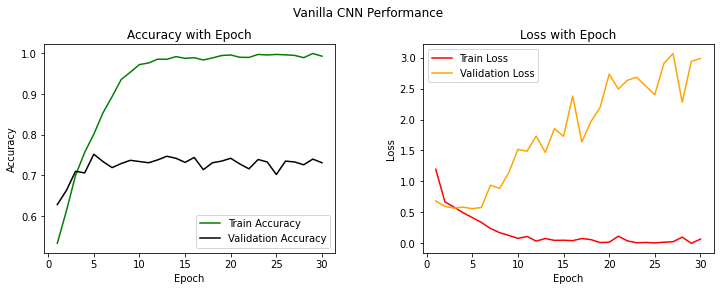

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("Vanilla CNN Performance")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="black")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="best")

epochs = list(range(1, EPOCHS+1))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="best")

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=INPUT_SHAPE))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(1, activation='sigmoid'))


model_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model_2.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/30
100/100 - 2s - loss: 0.7134 - accuracy: 0.5173 - val_loss: 0.6906 - val_accuracy: 0.5070
Epoch 2/30
100/100 - 2s - loss: 0.6955 - accuracy: 0.5567 - val_loss: 1.0855 - val_accuracy: 0.5140
Epoch 3/30
100/100 - 2s - loss: 0.6571 - accuracy: 0.6267 - val_loss: 0.6209 - val_accuracy: 0.6850
Epoch 4/30
100/100 - 2s - loss: 0.5994 - accuracy: 0.6767 - val_loss: 0.5720 - val_accuracy: 0.7230
Epoch 5/30
100/100 - 2s - loss: 0.5510 - accuracy: 0.7250 - val_loss: 0.5298 - val_accuracy: 0.7340
Epoch 6/30
100/100 - 2s - loss: 0.5069 - accuracy: 0.7490 - val_loss: 0.5894 - val_accuracy: 0.7390
Epoch 7/30
100/100 - 2s - loss: 0.4749 - accuracy: 0.7760 - val_loss: 0.5310 - val_accuracy: 0.7320
Epoch 8/30
100/100 - 2s - loss: 0.4275 - accuracy: 0.8110 - val_loss: 0.5521 - val_accuracy: 0.7700
Epoch 9/30
100/100 - 2s - loss: 0.3917 - accuracy: 0.8187 - val_loss: 0.5967 - val_accuracy: 0.7490
Epoch 10/30
100/100 - 2s - loss: 0.3335 - accuracy: 0.8570 - val_loss: 0.5896 - val_accuracy: 0.7940

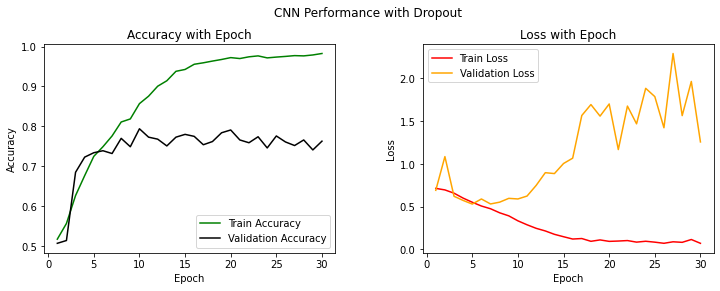

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("CNN Performance with Dropout")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="black")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="best")

epochs = list(range(1, EPOCHS+1))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="best")

In [ ]:
os.makedirs(os.path.join(INPUT_PATH, "models"), exist_ok=True)
model_2.save(os.path.join(INPUT_PATH, "models/catsvdogs.h5"))

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=50,
                                     zoom_range=0.3,
                                     shear_range=0.2,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest",
                                     )

val_generator = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


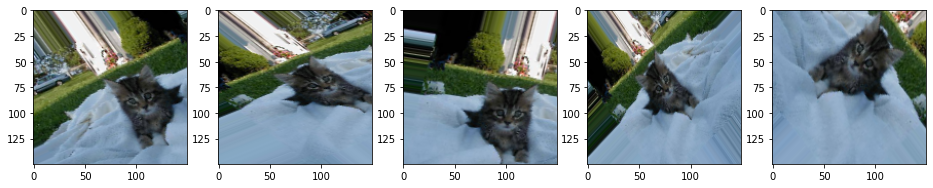

In [ ]:
def augmentation_viz(cls="cat"):

    if cls == "dog":
        img_id = np.random.randint(1, 1500)
    else:
        img_id = np.random.randint(1500, 3000)

    generator = train_generator.flow(train_imgs[img_id: img_id+1],
                                        train_labels[img_id:img_id+1],
                                        batch_size=1)

    generated = [next(generator) for i in range(0, 5)]
    fig, ax = plt.subplots(1, 5, figsize=(16, 6))

    print(f"Labels: {[item[1][0] for item in generated]}")
    l = [ax[i].imshow(generated[i][0][0]) for i in range(0,5)]
    
augmentation_viz(cls="cat")   

In [ ]:
train_datagen = train_generator.flow(train_imgs, train_labels_enc, batch_size=30)
val_datagen = val_generator.flow(val_imgs, val_labels_enc, batch_size=20)

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit(train_datagen, steps_per_epoch=100, epochs=100,
                              validation_data=val_datagen, validation_steps=50, 
                              verbose=1)     

Epoch 1/100
100/100 [==============================] - 14s 144ms/step - loss: 0.6916 - accuracy: 0.5173 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 14s 143ms/step - loss: 0.6787 - accuracy: 0.5657 - val_loss: 0.6670 - val_accuracy: 0.5980
Epoch 3/100
100/100 [==============================] - 14s 143ms/step - loss: 0.6618 - accuracy: 0.5930 - val_loss: 0.6653 - val_accuracy: 0.5930
Epoch 4/100
100/100 [==============================] - 14s 145ms/step - loss: 0.6512 - accuracy: 0.6123 - val_loss: 0.6655 - val_accuracy: 0.5870
Epoch 5/100
100/100 [==============================] - 14s 143ms/step - loss: 0.6318 - accuracy: 0.6443 - val_loss: 0.6000 - val_accuracy: 0.6680
Epoch 6/100
100/100 [==============================] - 14s 144ms/step - loss: 0.6253 - accuracy: 0.6427 - val_loss: 0.5844 - val_accuracy: 0.6930
Epoch 7/100
100/100 [==============================] - 15s 145ms/step - loss: 0.6136 - accuracy: 0.6560 - val_loss: 0.5761 -

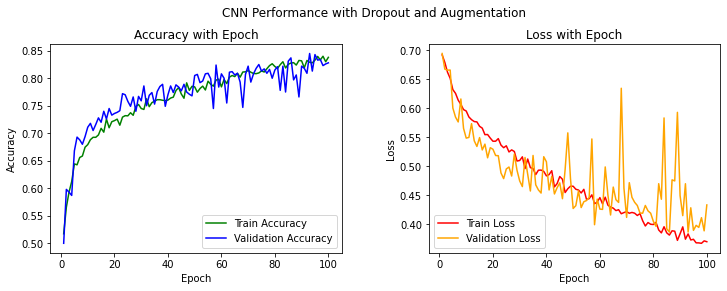

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("CNN Performance with Dropout and Augmentation")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 101))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="lower right")

epochs = list(range(1, 101))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="lower left")

In [ ]:
model.save(os.path.join(INPUT_PATH, "models/catsvdogs_augmentations.h5"))

In [ ]:
vgg = vgg16.VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=INPUT_SHAPE,
                )

output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(inputs=vgg.input, outputs=output, name="vgg_feature_extractor")

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False   

vgg_model.summary()     

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________

In [ ]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)

    assert features.shape == (input_imgs.shape[0], model.layers[-1].output.shape[1])
    return features
    
train_features = get_bottleneck_features(vgg_model, train_imgs_scaled)    
val_features = get_bottleneck_features(vgg_model, val_imgs_scaled)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

Train features shape: (3000, 8192)
Validation features shape: (1000, 8192)


In [ ]:
input_shape = vgg_model.output.shape[1]

model_3 = Sequential()

model_3.add(InputLayer(input_shape=(input_shape,)))

model_3.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))

model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.3))

model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_3.fit(x=train_features, y=train_labels_enc,
                    validation_data=(val_features, val_labels_enc),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4054 - accuracy: 0.8057 - val_loss: 0.2919 - val_accuracy: 0.8800
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2735 - accuracy: 0.8777 - val_loss: 0.3440 - val_accuracy: 0.8380
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2235 - accuracy: 0.9040 - val_loss: 0.4860 - val_accuracy: 0.8100
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1647 - accuracy: 0.9323 - val_loss: 0.3299 - val_accuracy: 0.8690
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1327 - accuracy: 0.9490 - val_loss: 0.4355 - val_accuracy: 0.8430
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1026 - accuracy: 0.9613 - val_loss: 0.2831 - val_accuracy: 0.8980
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0742 - accuracy: 0.9727 - val_loss: 0.3508 - val_accuracy: 0.8830
Epoch 

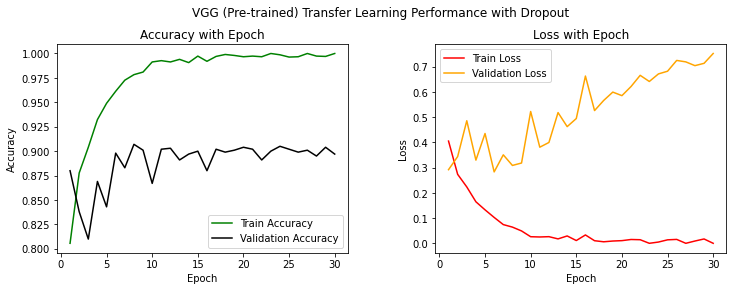

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("VGG (Pre-trained) Transfer Learning Performance with Dropout")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="black")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="best")

epochs = list(range(1, EPOCHS+1))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="best")

In [ ]:
model_3.save(os.path.join(INPUT_PATH, "models/vgg_pretrained.h5"))

In [ ]:
model_4 = Sequential()

model_4.add(vgg_model)

model_4.add(Dense(512, activation='relu', input_dim=input_shape))
model_4.add(Dropout(0.3))

model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.3))

model_4.add(Dense(1, activation="sigmoid"))

model_4.compile(loss="binary_crossentropy",
                optimizer = optimizers.RMSprop(lr=2e-5),
                metrics=["accuracy"])

In [ ]:
history = model_4.fit(train_datagen, steps_per_epoch=100, epochs=100,
                    validation_data=val_datagen, validation_steps=50, 
                    verbose=1) 

Epoch 1/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6449 - accuracy: 0.6187 - val_loss: 0.4863 - val_accuracy: 0.8080
Epoch 2/100
100/100 [==============================] - 20s 200ms/step - loss: 0.5580 - accuracy: 0.7223 - val_loss: 0.4034 - val_accuracy: 0.8280
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.4918 - accuracy: 0.7660 - val_loss: 0.3619 - val_accuracy: 0.8400
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.4682 - accuracy: 0.7760 - val_loss: 0.3365 - val_accuracy: 0.8550
Epoch 5/100
100/100 [==============================] - 20s 202ms/step - loss: 0.4378 - accuracy: 0.7897 - val_loss: 0.3229 - val_accuracy: 0.8480
Epoch 6/100
100/100 [==============================] - 20s 201ms/step - loss: 0.4298 - accuracy: 0.7980 - val_loss: 0.3106 - val_accuracy: 0.8610
Epoch 7/100
100/100 [==============================] - 20s 199ms/step - loss: 0.4197 - accuracy: 0.7987 - val_loss: 0.3022 -

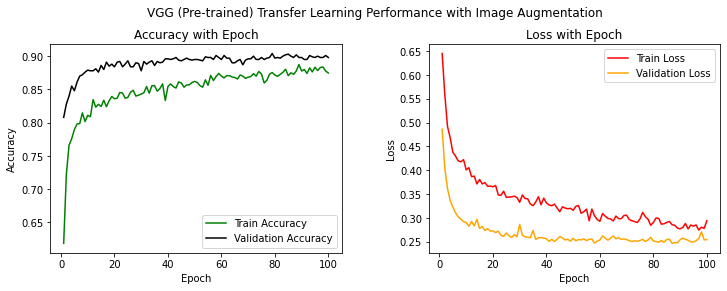

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("VGG (Pre-trained) Transfer Learning Performance with Image Augmentation")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 101))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="black")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="best")

epochs = list(range(1, 101))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="best")

In [ ]:
model_4.save(os.path.join(INPUT_PATH, 'models/vgg_pretrained_augmentations.h5'))

In [ ]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

vgg_model.summary()        

Model: "vgg_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 1

In [ ]:
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_feature_extractor (Funct (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [ ]:
history = model_4.fit(train_datagen, steps_per_epoch=100, epochs=100,
                      validation_data=val_datagen, validation_steps=50, 
                      verbose=1) 

Epoch 1/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2754 - accuracy: 0.8800 - val_loss: 0.2647 - val_accuracy: 0.8990
Epoch 2/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2771 - accuracy: 0.8840 - val_loss: 0.2664 - val_accuracy: 0.8940
Epoch 3/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2759 - accuracy: 0.8790 - val_loss: 0.2540 - val_accuracy: 0.8940
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2933 - accuracy: 0.8750 - val_loss: 0.2578 - val_accuracy: 0.8990
Epoch 5/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2779 - accuracy: 0.8787 - val_loss: 0.2553 - val_accuracy: 0.9030
Epoch 6/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2632 - accuracy: 0.8850 - val_loss: 0.2614 - val_accuracy: 0.9000
Epoch 7/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2891 - accuracy: 0.8837 - val_loss: 0.2576 -

KeyboardInterrupt: ignored

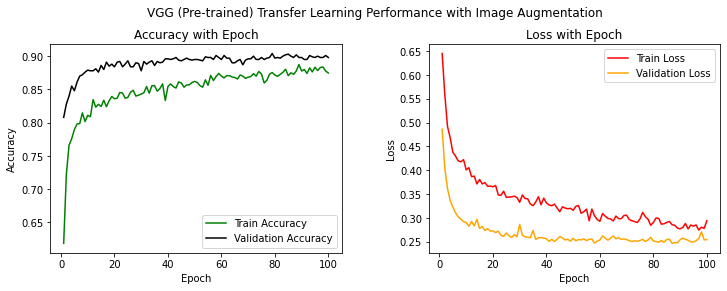

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("VGG (Pre-trained) Transfer Learning Performance with Image Augmentation")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 101))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="black")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="best")

epochs = list(range(1, 101))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="best")

In [ ]:
model.save(os.path.join(INPUT_PATH, 'models/vgg_finetunde_augmentations.h5')